### Run notebook to train a model and save the results to a .dat file

In the 3rd code cell, uncomment one of code sections for the model you want to output

In [16]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTENC

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import pickle 

import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
df = pd.read_csv('Data Set for Data Science Project.csv')

# convert the genre ratings in labels from 0 to 4
le = LabelEncoder()
for genre in ['Genre1', 'Genre2', 'Genre3']:
    df[genre + '_le'] = le.fit_transform(df[genre])

# Select Parameters

In [59]:
# parameters for all runs
random_state = 20
run_cross_validation = True # whether or not to run the cross validation cell

#### UNCOMMENT BELOW for genre1
# genre = 'Genre1_le'
# model_output_file = 'survey.genre1.pickle.dat'
# model = XGBClassifier(random_state=random_state,
#                       learning_rate=.1, 
#                       n_estimators=100, 
#                       objective='multi:softmax',
#                       eval_metric='mlogloss',
#                      max_depth=1)
# feature_names = ['XVar15', 'XVar20','XVar22','XVar13','XVar23','XVar14','XVar21','XVar10',
#  'XVar4','XVar6','XVar11','XVar9','XVar17','XVar12','XVar3','XVar8','XVar1','XVar2'] 
####

#### UNCOMMENT BELOW for genre2
# genre = 'Genre2_le'
# model_output_file = 'survey.genre2.pickle.dat'
# model = XGBClassifier(random_state=random_state,
#                       learning_rate=.1, 
#                       n_estimators=100, 
#                       objective='multi:softmax',
#                       eval_metric='mlogloss',
#                      max_depth=1)
# feature_names = ['XVar15', 'XVar20','XVar22','XVar13','XVar23','XVar14','XVar21','XVar10',
#  'XVar4','XVar6','XVar11','XVar9','XVar17','XVar12','XVar3','XVar8','XVar1','XVar2']

###

#### UNCOMMENT BELOW for genre3
genre = 'Genre3_le'
model_output_file = 'survey.genre3.pickle.dat'
model = XGBClassifier(random_state=random_state,
                      learning_rate=.3, 
                      n_estimators=100, 
                      objective='multi:softmax',
                      eval_metric='mlogloss',
                     max_depth=1, subsample=.8)
feature_names = ['XVar5','XVar7','XVar16','XVar17','XVar18', 'XVar19', 
                 'XVar15', 'XVar20','XVar22','XVar13','XVar23','XVar14','XVar21','XVar10',
                 'XVar4','XVar6','XVar11','XVar9','XVar17','XVar12','XVar3',
                 'XVar8','XVar1','XVar2']

####

#### UNCOMMENT BELOW for genre4
# genre = 'Genre4' # can be Genre1, Genre2, Genre3, or Genre4
# model_output_file = 'survey.genre4.pickle.dat'
# model = XGBClassifier(random_state=random_state,
#                       learning_rate=.2, 
#                       n_estimators=400, 
#                       objective='binary:logistic',
#                       eval_metric='logloss',
#                      max_depth=1)

# feature_names = ['XVar4','XVar6','XVar19','XVar5','XVar13','XVar3','XVar8','XVar1','XVar2']
####

In [60]:
### 
# index of variables that are categorical 
# make sure that XVar1, XVar2, and XVar8 are the last three values in the feature_names list
##
categorical_index = [x for x in range(0,len(feature_names)-3)] 

# Prepare Data

In [61]:
# get features and response variables
# * categorical variables - Genre1, Genre2, Genre3, Genre4
# * continuous variables - XVar1, XVar2, XVar8
# * multinomial variables - XVar3, XVar4, XVar6, Xvar9, XVar10, XVar11 
# * binary variables - XVar5, XVar7, XVar12 to Xvar 19, XVar20 to XVar 23

# split data into features and target variables
X = df.loc[:,feature_names].values
y = df.loc[:,[genre]].values.ravel()

In [62]:
# split data into stratified training and test set 80/20 split
X_training, X_testing, y_training, y_testing = train_test_split(X, 
                                                                y, 
                                                                test_size=0.2, 
                                                                random_state=random_state,
                                                               stratify=y)

In [63]:
# reports the confusion matrix with proper labels
# this makes it easier to see precision/recall for each rating

def report(model, X, y):
    model.predict(X)
    confusion = pd.DataFrame(confusion_matrix(y, model.predict(X).astype(str), labels=labels),
                             index=labels, columns=labels)
    return confusion

# Cross-Validate

Need to use contingency tables (predictions vs actual values) and precision and recall. Otherwise 

In [1]:
# get distinct values for genre ratings
labels = np.sort(df[genre].unique()).astype(str)

# run cross validation
# TODO: Use GridSearch to automatically choose best parameters
if run_cross_validation:
    skf = StratifiedKFold(n_splits=3, shuffle=True)

    # cross validate results, tuning for number of trees and learning rate
    for train_index, test_index in skf.split(X_training, y_training):
                
        X_train, X_test = X_training[train_index], X_training[test_index]
        y_train, y_test = y_training[train_index], y_training[test_index]
        
        # oversample the train data
        smote_nc = SMOTENC(categorical_features=categorical_index, random_state=random_state)
        
        X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

        model.fit(X_resampled, y_resampled, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
        
        print('results of oversampled training data')
        print(classification_report(y_resampled.astype(str), model.predict(X_resampled).astype(str), target_names=labels))
        
        print('results of current fold test set')
        print(classification_report(y_test, model.predict(X_test), target_names=labels))
        
        print('results on current fold training data')
        print(report(model, X_train, y_train.astype(str)))
        
        print('results on current fold test set')
        print(report(model, X_test, y_test.astype(str)))
        
        print('feature importances')
        print(sorted(list(zip(model.feature_importances_, feature_names))))

NameError: name 'np' is not defined

In [65]:
# train model on all data and get results on test set

# oversample the train data
smote_nc = SMOTENC(categorical_features=categorical_index, random_state=random_state)
X_resampled, y_resampled = smote_nc.fit_resample(X_training, y_training)

model.fit(X_resampled, y_resampled, eval_set=[(X_testing, y_testing)], early_stopping_rounds=10, verbose=False)

# show results
print('Results on training set')
print(classification_report(y_training, model.predict(X_training), target_names=labels))

print('Results on test set')
print(classification_report(y_testing, model.predict(X_testing), target_names=labels))

print('Confusion matrix for training set')
print(report(model, X_training, y_training.astype(str)))

print('Confusion matrix for test set')
print(report(model, X_testing, y_testing.astype(str)))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=20,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

Results on training set
              precision    recall  f1-score   support

           0       0.88      0.49      0.63      3939
           1       0.19      0.26      0.22       588
           2       0.06      0.35      0.10       111
           3       0.05      0.26      0.08       103
           4       0.03      0.27      0.05        59

   micro avg       0.45      0.45      0.45      4800
   macro avg       0.24      0.33      0.22      4800
weighted avg       0.75      0.45      0.55      4800

Results on test set
              precision    recall  f1-score   support

           0       0.87      0.49      0.62       984
           1       0.17      0.23      0.19       147
           2       0.05      0.32      0.09        28
           3       0.03      0.15      0.05        26
           4       0.01      0.07      0.01        15

   micro avg       0.44      0.44      0.44      1200
   macro avg       0.23      0.25      0.19      1200
weighted avg       0.74      0.44

# Save Model

In [66]:
# save model to file
pickle.dump(model, open(model_output_file, "wb"))

# check that model file loads
loaded_model = pickle.load(open(model_output_file, "rb"))

loaded_model.predict_proba([X_testing[0]]) # predict one a row to make sure loaded model works

array([[0.3696543 , 0.36839586, 0.06074886, 0.02836282, 0.17283812]],
      dtype=float32)

# Analyze Model

In [67]:
# see feature importances
sorted(list(zip(model.feature_importances_, feature_names)))

[(0.0, 'XVar17'),
 (0.006, 'XVar18'),
 (0.006, 'XVar21'),
 (0.01, 'XVar22'),
 (0.01, 'XVar5'),
 (0.016, 'XVar13'),
 (0.016, 'XVar16'),
 (0.02, 'XVar19'),
 (0.02, 'XVar23'),
 (0.022, 'XVar9'),
 (0.024, 'XVar14'),
 (0.026, 'XVar7'),
 (0.036, 'XVar15'),
 (0.036, 'XVar6'),
 (0.04, 'XVar12'),
 (0.052, 'XVar20'),
 (0.054, 'XVar10'),
 (0.056, 'XVar17'),
 (0.06, 'XVar2'),
 (0.066, 'XVar1'),
 (0.072, 'XVar4'),
 (0.09, 'XVar11'),
 (0.104, 'XVar3'),
 (0.158, 'XVar8')]

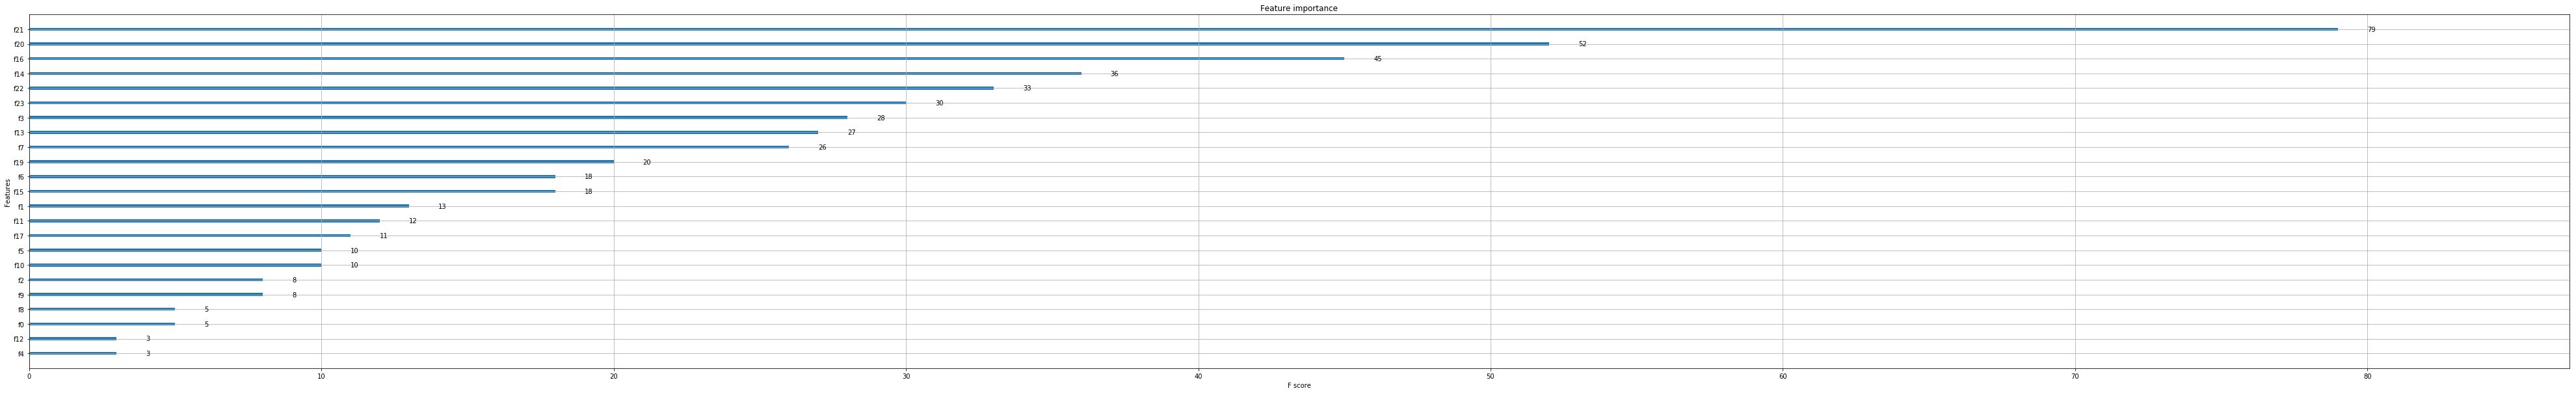

In [68]:
# plot feature importances
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

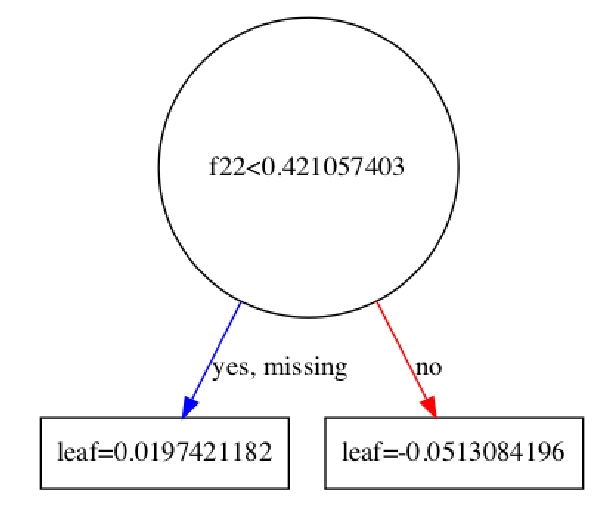

In [69]:
# plot one decision tree to see what it looks like
xgb.plot_tree(model, num_trees=100)
plt.rcParams['figure.figsize'] = [70, 10]
plt.show()